In [1]:
import transpath
print(transpath.__file__)

/home/snikem/projectHerostic/transpath/__init__.py


In [3]:
def get_job_scheduler():
    if 'SLURM_JOB_ID' in os.environ:
        return 'SLURM'
    elif 'PBS_JOBID' in os.environ:
        return 'PBS'
    elif 'LSB_JOBID' in os.environ:
        return 'LSF'
    else:
        return 'LOCAL'

print("Scheduler:", get_job_scheduler())

Scheduler: LOCAL


In [3]:
import lightning as L
from transpath.lit_model import LitTransPath
from transpath.transpath import TransPathModel
from transpath.datamodule import GridDataModule
from lightning.pytorch.callbacks import ModelCheckpoint
import torch
import lightning as L
import torch
import os

# Ограничить общее число потоков PyTorch (влияет на intra-op параллелизм)
torch.set_num_threads(30)

# Определяем, сколько GPU доступно
available_gpus = torch.cuda.device_count()
devices_to_use = [1]
mode = "h"
dm = GridDataModule(
    data_path="/home/snikem/data/train/",
    mode=mode,
    batch_size=32,
    num_workers=0,   # ВАЖНО для ipynb
)

model = TransPathModel(in_channels=2, out_channels=1)

lit = LitTransPath(
    model=model,
    mode=mode,
    scheduler_type="none"  # временно
)

checkpoint_callback = ModelCheckpoint(
    dirpath="/home/snikem/data/checkpoints",
    filename="transpath-{epoch:02d}-{val_loss:.4f}" + "___" + mode,
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    save_last=True,
)

trainer = L.Trainer(
    accelerator="gpu" if available_gpus > 0 else "cpu",
    devices=devices_to_use,
    max_epochs=30,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
    enable_model_summary=True,  # ← явно включить (по умолчанию True)
        limit_train_batches=1000,   # обучение: только первые 10 батчей
        limit_val_batches=1000,
)
dm.setup("fit")
batch = next(iter(dm.train_dataloader()))

map_design, start, goal, gt = batch
print("map_design:", map_design.shape)
print("start:", start.shape)
print("goal:", goal.shape)

x = lit.prepare_inputs(map_design, start, goal)
print("model input:", x.shape)

trainer.fit(lit, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]


Dataset statistics: None
Dataset split:
  Train: 409600 samples
  Val:   51200 samples
  Test:  51200 samples
map_design: torch.Size([32, 1, 1, 64, 64])
start: torch.Size([32, 1, 1, 64, 64])
goal: torch.Size([32, 1, 1, 64, 64])
model input: torch.Size([32, 2, 64, 64])
Data verified for mode 'h'



  | Name  | Type           | Params | Mode  | FLOPs | In sizes       | Out sizes     
-------------------------------------------------------------------------------------------
0 | model | TransPathModel | 937 K  | train | 1.5 B | [1, 2, 64, 64] | [1, 1, 64, 64]
1 | loss  | L1Loss         | 0      | train | 0     | ?              | ?             
-------------------------------------------------------------------------------------------
937 K     Trainable params
0         Non-trainable params
937 K     Total params
3.752     Total estimated model params size (MB)
135       Modules in train mode
0         Modules in eval mode
1.5 B     Total Flops


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

Training: |                                                                               | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [5]:
import torch
from transpath.transpath import TransPathModel

model_path = '/home/snikem/data/checkpoints/transpath-epoch=23-val_loss=18.6900___h.ckpt'
dataset_dir = '/home/snikem/data/test/'
mode = 'h' 
output = "/home/snikem/res/" + "" + mode
# 1. Загрузите чекпоинт
checkpoint = torch.load(model_path, map_location="cpu")  # или "cuda"

# 2. Создайте модель вручную с теми же параметрами, что и при обучении
eval_model = TransPathModel(in_channels=2, out_channels=1)  # ← укажите правильные!

# 3. Загрузите веса (убедитесь, что ключи совпадают)
state_dict = checkpoint["state_dict"]

# Если веса сохранены под префиксом "model." (потому что LitTransPath имеет self.model)
# то нужно убрать этот префикс:
from collections import OrderedDict
clean_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith("model."):
        clean_state_dict[k[6:]] = v  # убираем "model."
    else:
        clean_state_dict[k] = v

eval_model.load_state_dict(clean_state_dict)
eval_model.eval()

TransPathModel(
  in_channels=2, out_channels=1, hidden_channels=64, resolution=(64, 64)
  (encoder): Encoder(
    in_channels=2, hidden_channels=64, downsample_steps=3
    (layers): ModuleList(
      (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1-3): 3 x Sequential(
        (0): ResNetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (dropout): Dropout(p=0.15, inplace=False)
          (silu): SiLU()
          (idConv): Identity()
        )
        (1): Downsample(
          in_channels=64, scale_factor=0.5, mode=nearest
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
  (decoder): Decoder(
    hidden_channels=64, out_channels=1, upsample

In [14]:
import torch
from transpath.data_prep import GridDataset
from transpath.datamodule import GridDataModule
from matplotlib import pyplot as plt
from transpath.lit_model import LitTransPath
lit = LitTransPath(
    model=eval_model,
    mode=mode,
    scheduler_type="none"  # временно
)
dm = GridDataModule(
    data_path="/home/snikem/data/train/",
    mode=mode,
    batch_size=32,
    num_workers=0,   # ВАЖНО для ipynb
)

dm.setup("fit")
batch = next(iter(dm.train_dataloader()))

map_design, start, goal, gt = batch
x = lit.prepare_inputs(map_design, start, goal)

map_design, start, goal, gt_hmap = batch
inputs = lit.prepare_inputs(map_design, start, goal)
predictions = (eval_model(inputs) + 1) / 2


for i in range(len(indices)):
    plt.imshow(gt_hmap[i, 0], cmap='gray')
    plt.show()
    plt.imshow(gt_hmap[i, 0].cpu().numpy(), cmap='gray')
    plt.show()

for i in range(min(len(batch[0]), len(indices))):  # или range(5)
    # Убедитесь, что берёте [H, W]
    gt_img = gt_hmap[i, 0].cpu().numpy()        # форма [64, 64]
    pred_img = predictions[i, 0].cpu().numpy()  # форма [64, 64]

    plt.imshow(gt_img, cmap='gray')
    plt.show()
    plt.imshow(pred_img, cmap='gray')
    plt.show()



map_design, start, goal, gt_hmap = batch
inputs = lit.prepare_inputs(map_design, start, goal)
predictions = (eval_model(inputs) + 1) / 2

for i in range(len(indices)):
    plt.imshow(1 - (map_design[i, 0] + 5 * start[i, 0] + 5 * goal[i, 0]), cmap='gray')
    plt.show()
    plt.imshow(gt_hmap[i, 0].cpu().numpy(), cmap='gray')
    plt.show()

Dataset statistics: None
Dataset split:
  Train: 409600 samples
  Val:   51200 samples
  Test:  51200 samples


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Dataset statistics: None
Dataset split:
  Train: 409600 samples
  Val:   51200 samples
  Test:  51200 samples


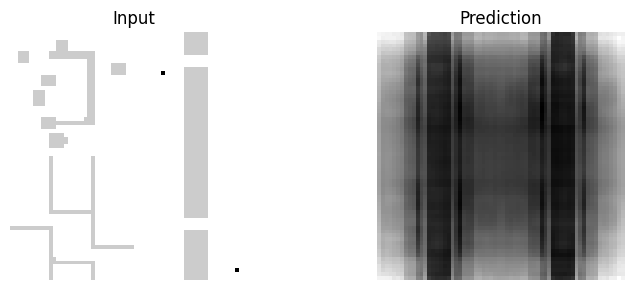

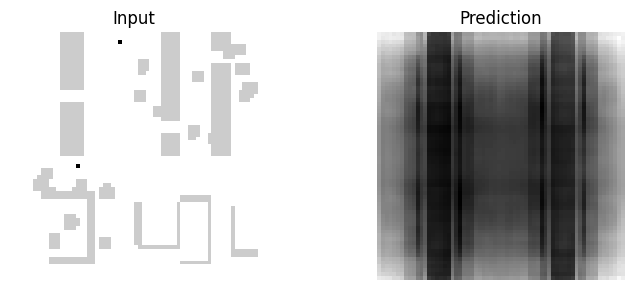

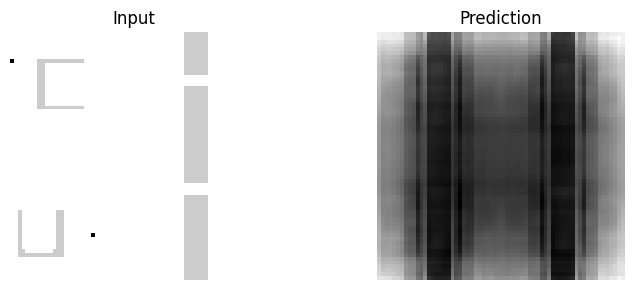

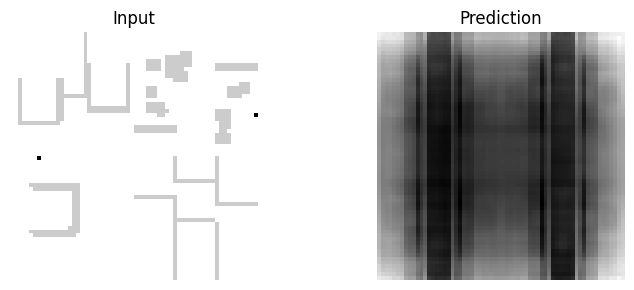

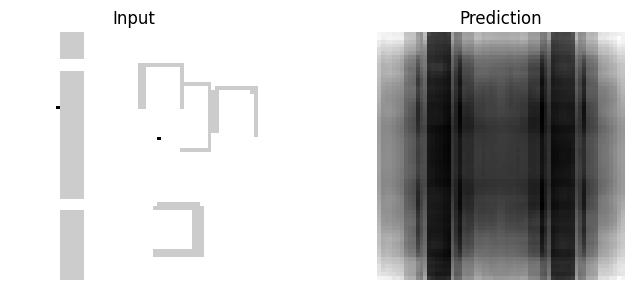

In [18]:
import torch
from transpath.data_prep import GridDataset
from transpath.datamodule import GridDataModule
from matplotlib import pyplot as plt
from transpath.lit_model import LitTransPath

# --- Ваши объекты (как в вашем коде) ---
mode = "h"
dm = GridDataModule(
    data_path="/home/snikem/data/train/",
    mode=mode,
    batch_size=32,
    num_workers=0,
)
dm.setup("fit")
batch = next(iter(dm.train_dataloader()))

map_design, start, goal, gt = batch

# Загрузите или определите eval_model (предполагается, что он уже есть)
# Например: eval_model = lit.model  или загружена отдельно

lit = LitTransPath(model=eval_model, mode=mode, scheduler_type="none")

# --- Формируем input ТОЧНО КАК ПРИ ОБУЧЕНИИ ---
inputs = lit.prepare_inputs(map_design, start, goal)

# --- Предсказание ---
with torch.no_grad():
    predictions = (eval_model(inputs) + 1) / 2

# --- Визуализация: только input и prediction ---
for i in range(5):
    # Формируем визуализацию входа и убираем лишние измерения
    input_vis = 1 - (map_design[i, 0] + 5 * start[i, 0] + 5 * goal[i, 0])
    input_vis = input_vis.squeeze().cpu().numpy()  # ← КЛЮЧЕВОЙ ШАГ
    
    pred_vis = predictions[i, 0].squeeze().cpu().numpy()

    plt.figure(figsize=(8, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(input_vis, cmap='gray')
    plt.title("Input")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_vis, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [20]:
print("Prediction min/max per sample:")
for i in range(5):
    p = predictions[i, 0]
    print(f"  Sample {i}: {p.min().item():.3f} – {p.max().item():.3f}")

Prediction min/max per sample:
  Sample 0: 0.004 – 0.015
  Sample 1: 0.004 – 0.015
  Sample 2: 0.004 – 0.015
  Sample 3: 0.005 – 0.015
  Sample 4: 0.005 – 0.015
